In [313]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

from math import sqrt
import statsmodels.stats.api as sms

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [129]:
np.set_printoptions(precision=2)

In [130]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import get_variance, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [131]:
# aggregate both visual embeddings and language embeddings
def aggregate_embeddings_visual_and_language(input_struct,n_sample_per_visual,n_sample_per_language):
	words=input_struct['words']
	embed_dict=dict()
	for word in words:
		n_sample_v = min(len(input_struct['embeds'][word]['visual']), n_sample_per_visual)
		visual_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['visual'],n_sample_v)),axis=0)
		n_sample_l = min(len(input_struct['embeds'][word]['language']), n_sample_per_language)
		language_temp=np.mean(np.array(random.sample(input_struct['embeds'][word]['language'],n_sample_l)),axis=0)
		#embed_dict[word]=dict(visual=np.expand_dims(visual_temp,axis=0),language=language_temp)
		embed_dict[word]=dict(visual=visual_temp,language=np.squeeze(language_temp))
	return dict(embeds=embed_dict,words=words)

In [132]:
def get_alignment_strength(struct,concepts,relative):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    if relative:
        return permutation(z_0,z_1,n_sim=100)[0]
    else:
        return compute_alignment_strength(z_0,z_1)

In [133]:
def get_variance(struct):
    words=struct["words"]
    visual_variance=dict()
    language_variance=dict()
    for word in words:
        visual_embeddings=struct["embeds"][word]["visual"]
        visual_variance[word]=np.mean(np.linalg.norm(visual_embeddings-np.mean(visual_embeddings,axis=0),axis=1))
        language_embeddings=struct["embeds"][word]["language"]
        language_variance[word]=np.mean(np.linalg.norm(language_embeddings-np.mean(language_embeddings,axis=0),axis=1))
    return visual_variance,language_variance

In [134]:
def get_distinctness(struct):
    words=struct["words"]
    visual_centers=dict()
    language_centers=dict()
    for word in words:
        visual_embeddings=np.array(struct["embeds"][word]["visual"])
        visual_centers[word]=np.mean(visual_embeddings,axis=0)
        language_embeddings=np.array(struct["embeds"][word]["language"])
        language_centers[word]=np.mean(language_embeddings,axis=0)
    visual_distinctness=dict()
    language_distinctness=dict()
    for word in words:
        visual_distances=[np.linalg.norm(visual_centers[word]-visual_centers[temp]) for temp in words]
        visual_distinctness[word]=np.sum(visual_distances)/(len(visual_distances)-1)
        language_distances=[np.linalg.norm(language_centers[word]-language_centers[temp]) for temp in words]
        language_distinctness[word]=np.sum(language_distances)/(len(visual_distances)-1)
    return visual_distinctness,language_distinctness

In [135]:
def get_distinctness_from_nearest_5(struct):
    words=struct["words"]
    visual_centers=dict()
    language_centers=dict()
    for word in words:
        visual_embeddings=np.array(struct["embeds"][word]["visual"])
        visual_centers[word]=np.mean(visual_embeddings,axis=0)
        language_embeddings=np.array(struct["embeds"][word]["language"])
        language_centers[word]=np.mean(language_embeddings,axis=0)
    visual_distinctness=dict()
    language_distinctness=dict()
    for word in words:
        visual_distances=[np.linalg.norm(visual_centers[word]-visual_centers[temp]) for temp in words]
        visual_distinctness[word]=np.sum(sorted(visual_distances)[:6])/5
        language_distances=[np.linalg.norm(language_centers[word]-language_centers[temp]) for temp in words]
        language_distinctness[word]=np.sum(sorted(language_distances)[:6])/5
    return visual_distinctness,language_distinctness

In [136]:
def print_statistics(value_dict,name):
    print("mean "+name+": ",np.mean(list(value_dict.values())),"95% confidence:",sms.DescrStatsW(list(value_dict.values())).tconfint_mean())

----

In [137]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [138]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [139]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

----

In [375]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_swav_bert_window5_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_swav_bert_window5_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [302]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_ll_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_ll_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [376]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [345]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_glove_20.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_glove_20.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [377]:
noun_visual_variance,noun_language_variance=get_variance(vg_noun_data)
verb_visual_variance,verb_language_variance=get_variance(vg_verb_data)

In [378]:
noun_visual_distinctness,noun_language_distinctness=get_distinctness_from_nearest_5(vg_noun_data)
verb_visual_distinctness,verb_language_distinctness=get_distinctness_from_nearest_5(vg_verb_data)

In [379]:
noun_visual_distinctness,noun_language_distinctness=get_distinctness(vg_noun_data)
verb_visual_distinctness,verb_language_distinctness=get_distinctness(vg_verb_data)

----

In [380]:
print("vg noun visual:")
print_statistics(noun_visual_variance,"variance")

print("vg verb visual:")
print_statistics(verb_visual_variance,"variance")

print("vg noun language:")
print_statistics(noun_language_variance,"variance")

print("vg verb language:")
print_statistics(verb_language_variance,"variance")

vg noun visual:
mean variance:  0.7456255 95% confidence: (0.7313347863563777, 0.7599162971425317)
vg verb visual:
mean variance:  0.8547193 95% confidence: (0.843691742700127, 0.865746833600812)
vg noun language:
mean variance:  0.23496059 95% confidence: (0.23058949309298424, 0.23933167757879667)
vg verb language:
mean variance:  0.23424268 95% confidence: (0.22957035044252097, 0.23891500805682434)


In [381]:
print("vg noun visual:")
print_statistics(noun_visual_distinctness,"distinctness")

print("vg verb visual:")
print_statistics(verb_visual_distinctness,"distinctness")

print("vg noun language:")
print_statistics(noun_language_distinctness,"distinctness")

print("vg verb language:")
print_statistics(verb_language_distinctness,"distinctness")

vg noun visual:
mean distinctness:  0.7549399509112694 95% confidence: (0.7404506536838903, 0.7694292481386477)
vg verb visual:
mean distinctness:  0.5596341619624123 95% confidence: (0.5482436054669052, 0.5710247184579195)
vg noun language:
mean distinctness:  10.746912572290988 95% confidence: (10.64458169860023, 10.849243445981756)
vg verb language:
mean distinctness:  10.193343922216762 95% confidence: (10.097293624633718, 10.289394219799807)


In [384]:
def t_test(variance1,variance2):
    print(scipy.stats.ttest_ind(list(variance1.values()),list(variance2.values())))

In [385]:
t_test(noun_visual_variance,verb_visual_variance)

Ttest_indResult(statistic=-11.914424595091827, pvalue=2.2293687450184854e-28)


In [386]:
t_test(noun_language_variance,verb_language_variance)

Ttest_indResult(statistic=0.2211976608034415, pvalue=0.8250465421894277)


In [387]:
t_test(noun_visual_distinctness,verb_visual_distinctness)

Ttest_indResult(statistic=20.890434423595835, pvalue=6.975059489908717e-67)


In [388]:
t_test(noun_language_distinctness,verb_language_distinctness)

Ttest_indResult(statistic=7.77568618028595, pvalue=5.905526651433397e-14)


In [389]:
temp1=list(noun_visual_variance.values())+list(noun_visual_distinctness.values())+ \
    list(noun_language_variance.values())+list(noun_language_distinctness.values())
temp2=["v_var"]*len(noun_visual_variance)+["v_dist"]*len(noun_visual_distinctness)+ \
    ["l_var"]*len(noun_language_variance)+["l_dist"]*len(noun_language_distinctness)

df1=pd.DataFrame(dict(
    value=temp1,
    measure=temp2
))
df1["type"]="noun"

In [390]:
temp1=list(verb_visual_variance.values())+list(verb_visual_distinctness.values())+ \
    list(verb_language_variance.values())+list(verb_language_distinctness.values())
temp2=["v_var"]*len(verb_visual_variance)+["v_dist"]*len(verb_visual_distinctness)+ \
    ["l_var"]*len(verb_language_variance)+["l_dist"]*len(verb_language_distinctness)
df2=pd.DataFrame(dict(
    value=temp1,
    measure=temp2
))
df2["type"]="verb"

In [391]:
df=pd.concat([df1,df2])

In [392]:
df

,value,measure,type
0,0.887156,v_var,noun
1,0.764683,v_var,noun
2,0.863362,v_var,noun
3,0.767272,v_var,noun
4,0.885647,v_var,noun
...,...,...,...
835,10.466222,l_dist,verb
836,10.041847,l_dist,verb
837,11.113531,l_dist,verb
838,10.076156,l_dist,verb


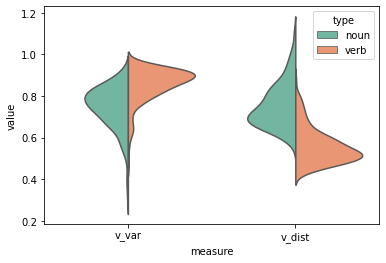

In [398]:
fig, ax =plt.subplots()
ax = sns.violinplot(x="measure", y="value", hue="type",
                    data=df[(df.measure=="v_var") | (df.measure=="v_dist")],split=True,palette="Set2",inner=None)
plt.savefig("aa.png")

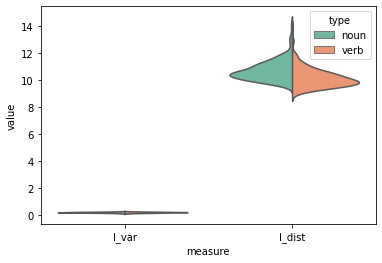

In [394]:
fig, ax =plt.subplots()
ax = sns.violinplot(x="measure", y="value", hue="type",
                    data=df[(df.measure=="l_var") | (df.measure=="l_dist")],split=True,palette="Set2",inner=None)

In [362]:
temp1=list()
noun_visual_dprime=list()
noun_language_dprime=list()

for i,j in zip(list(noun_visual_variance.values()),list(noun_visual_distinctness.values())):
    noun_visual_dprime.append(i/j)
    temp1.append(i/j)
for i,j in zip(list(noun_language_variance.values()),list(noun_language_distinctness.values())):
    noun_language_dprime.append(i/j)
    temp1.append(i/j)
    
temp2=["visual"]*len(noun_visual_variance)+["language"]*len(noun_language_variance)

df1=pd.DataFrame(dict(
    value=temp1,
    modality=temp2
))
df1["type"]="noun"

In [363]:
temp1=list()
verb_visual_dprime=list()
verb_language_dprime=list()

for i,j in zip(list(verb_visual_variance.values()),list(verb_visual_distinctness.values())):
    verb_visual_dprime.append(i/j)
    temp1.append(i/j)
for i,j in zip(list(verb_language_variance.values()),list(verb_language_distinctness.values())):
    verb_language_dprime.append(i/j)
    temp1.append(i/j)
    
temp2=["visual"]*len(verb_visual_variance)+["language"]*len(verb_language_variance)

df2=pd.DataFrame(dict(
    value=temp1,
    modality=temp2
))
df2["type"]="verb"

In [364]:
df=pd.concat([df1,df2])

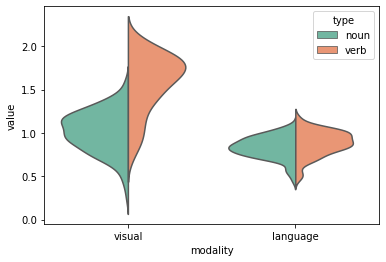

In [365]:
fig, ax =plt.subplots()
ax = sns.violinplot(x="modality", y="value", hue="type",
                    data=df,split=True,palette="Set2",inner=None)

In [366]:
scipy.stats.ttest_ind(noun_visual_dprime,verb_visual_dprime)

Ttest_indResult(statistic=-19.25636097125407, pvalue=1.2964328003711668e-59)

In [367]:
scipy.stats.ttest_ind(noun_language_dprime,verb_language_dprime)

Ttest_indResult(statistic=-3.690995120532551, pvalue=0.00025294743993376254)

In [368]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [369]:
cohend(list(noun_visual_variance.values()),list(verb_visual_variance.values()))

-1.191449385839542

In [370]:
cohend(list(noun_language_variance.values()),list(verb_language_variance.values()))

-0.12680306919833279

In [371]:
cohend(list(noun_visual_distinctness.values()),list(verb_visual_distinctness.values()))

1.9132512110642272

In [372]:
cohend(list(noun_language_distinctness.values()),list(verb_language_distinctness.values()))

0.7315074047229115

In [373]:
cohend(noun_visual_dprime,verb_visual_dprime)

-1.8792284076570134

In [374]:
cohend(noun_language_dprime,verb_language_dprime)

-0.3602042407380397